Look at effect on m5 as we transition through different versions of the throughput files.

In [1]:
import os
import shutil
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.phot_utils as phot_utils
import syseng_throughputs as se

The survey simulations used 1.5 for simulations v1.5 through v3.2 (perhaps switching to 1.6 at some point, but this was a minor change). Then moved to v1.9 for v3.3.
Not all tags in the repo corresponded to meaningful changes in the throughput files (there are some tags which correspond to software or repository layout changes). 

In [2]:
# Check out a new copy of the repo into a new directory, 
# so we can compare and switch tags without worrying about other in-progress work

repocopy = 'syseng_tags'
# Remove previous copy of this directory, if it exists.
try:
    shutil.rmtree(repocopy)
except OSError:
    pass
gitcommand = 'git clone https://github.com/lsst-pst/syseng_throughputs.git %s' % repocopy
subprocess.run(args=gitcommand.split(), check=True)

Cloning into 'syseng_tags'...


CompletedProcess(args=['git', 'clone', 'https://github.com/lsst-pst/syseng_throughputs.git', 'syseng_tags'], returncode=0)

In [3]:
defaultDirs = se.setDefaultDirs(rootDir=repocopy)
defaultDirs

{'detector': 'syseng_tags/components/camera/detector/joint_minimum',
 'lens1': 'syseng_tags/components/camera/lens1',
 'lens2': 'syseng_tags/components/camera/lens2',
 'lens3': 'syseng_tags/components/camera/lens3',
 'filters': 'syseng_tags/components/camera/filters',
 'mirror1': 'syseng_tags/components/telescope/mirror1',
 'mirror2': 'syseng_tags/components/telescope/mirror2',
 'mirror3': 'syseng_tags/components/telescope/mirror3',
 'atmosphere': 'syseng_tags/siteProperties'}

In [4]:
# Read some common (and should not change over time) dark sky and atmospheric throughput files)
atmos = phot_utils.Bandpass()
atmos.read_throughput(os.path.join(defaultDirs['atmosphere'], 'atmos_10_aerosol.dat'))

darksky = phot_utils.Sed()
darksky.read_sed_flambda(os.path.join(defaultDirs['atmosphere'], 'darksky.dat'))

In [5]:
tags = ['1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9']

lsst_system = {}
lsst_hardware = {}
m5s = {}
for t in tags:
    gitcommand = f"git checkout tags/{t}"
    pp = subprocess.run(args=gitcommand.split(), capture_output=True, check=True, cwd=repocopy)
    gitcommand = "git status"
    pp = subprocess.run(args=gitcommand.split(), capture_output=True, check=True, cwd=repocopy)
    print(pp.stdout.decode("utf-8"))
    lsst_hardware[t], lsst_system[t] = se.buildHardwareAndSystem(defaultDirs, 
                                                                 atmosphereOverride=atmos, 
                                                                 addLosses=True)
    m5s[t] = se.makeM5(lsst_hardware[t], lsst_system[t], darksky=darksky, sky_mags=None,
           exptime={'u': 30, 'g': 15, 'r': 15, 'i': 15, 'z': 15, 'y': 15},
           nexp={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
           readnoise=8.8, othernoise=0, darkcurrent=0.2,
           effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=None)        

HEAD detached at 1.3
nothing to commit, working tree clean

HEAD detached at 1.4
nothing to commit, working tree clean

HEAD detached at 1.5
nothing to commit, working tree clean

HEAD detached at 1.6
nothing to commit, working tree clean

HEAD detached at 1.7
nothing to commit, working tree clean

HEAD detached at 1.8
nothing to commit, working tree clean

HEAD detached at 1.9
nothing to commit, working tree clean



In [6]:
other = [] # git sha here if necessary
for t in other:
    gitcommand = f"cd {repocopy} git checkout {t}"
    pp = subprocess.run(args=gitcommand.split(), capture_output=True, check=True)
    gitcommand = "git status"
    pp = subprocess.run(args=gitcommand.split(), capture_output=True, check=True, cwd=repocopy)
    print(pp.stdout.decode("utf-8"))
    lsst_hardware[t], lsst_system[t] = se.buildHardwareAndSystem(defaultDirs, 
                                                                 atmosphereOverride=atmos, 
                                                                 addLosses=True)
    m5s[t] = se.makeM5(lsst_hardware[t], lsst_system[t], darksky=darksky, sky_mags=None,
           exptime={'u': 30, 'g': 15, 'r': 15, 'i': 15, 'z': 15, 'y': 15},
           nexp={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
           readnoise=8.8, othernoise=0, darkcurrent=0.2,
           effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=None) 

In [7]:
shutil.rmtree(repocopy)

In [8]:
# Check on status in "real" repo
gitcommand = f"git status"
pp = subprocess.run(args=gitcommand.split(), capture_output=True, check=True)
print(pp.stdout.decode("utf-8"))

On branch tickets/OPSIM-1160
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   m5_changes.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.idea/
	../syseng_throughputs.egg-info/

no changes added to commit (use "git add" and/or "git commit -a")



In [9]:
# Just to track other input conditions
m5s['1.9']

,nexp,exptime,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.0,30.0,0.92,0.80824,23.051983,45.303229,26.524237,0.022928,0.035351,0.470116,0.037534,22.967681,0.543325,0.343781,23.696948,405.542696,23.9,23.4
g,2.0,15.0,0.87,0.76714,22.253839,463.634122,28.508375,0.142565,0.173458,0.212949,0.038796,24.511574,0.159045,0.083120,24.902441,830.797119,25.0,24.6
r,2.0,15.0,0.83,0.73426,21.197579,988.626863,28.360838,0.124451,0.139813,0.126369,0.039067,24.564727,0.080846,0.039552,24.478566,1071.592979,24.7,24.3
i,2.0,15.0,0.80,0.70960,20.462795,1588.280513,28.171396,0.104526,0.114164,0.095764,0.039214,24.516816,0.051845,0.024281,24.103234,1271.704248,24.0,23.6
z,2.0,15.0,0.78,0.69316,19.606305,2381.945498,27.782264,0.073041,0.077792,0.068417,0.039330,24.354430,0.035176,0.015802,23.540091,1492.761106,23.3,22.9
y,2.0,15.0,0.76,0.67672,18.601512,2717.111941,26.817819,0.030046,0.035172,0.171009,0.039354,23.825489,0.030969,0.013657,22.536956,1546.914704,22.1,21.7


In [10]:
m5_srd_min = m5s['1.9']['m5_min']
m5_srd_fid = m5s['1.9']['m5_fid']

In [11]:
m5 = pd.DataFrame([m5s[t]['m5'] for t in m5s] + [m5_srd_fid, m5_srd_min], index=[[f'm5 for {t}' for t in m5s] + ['m5 SRD design', 'm5 SRD minimum']])

In [12]:
m5.round(2)

,u,g,r,i,z,y
m5 for 1.3,24.00,24.81,24.35,23.92,23.34,22.45
m5 for 1.4,23.98,24.81,24.35,23.92,23.34,22.45
m5 for 1.5,23.98,24.81,24.35,23.92,23.34,22.45
m5 for 1.6,23.92,24.79,24.34,23.92,23.35,22.46
m5 for 1.7,24.07,24.82,24.36,23.93,23.36,22.47
m5 for 1.8,23.92,24.85,24.38,23.97,23.39,22.47
m5 for 1.9,23.70,24.90,24.48,24.10,23.54,22.54
m5 SRD design,23.90,25.00,24.70,24.00,23.30,22.10
m5 SRD minimum,23.40,24.60,24.30,23.60,22.90,21.70


Text(0.5, 0, 'Throughputs Version')

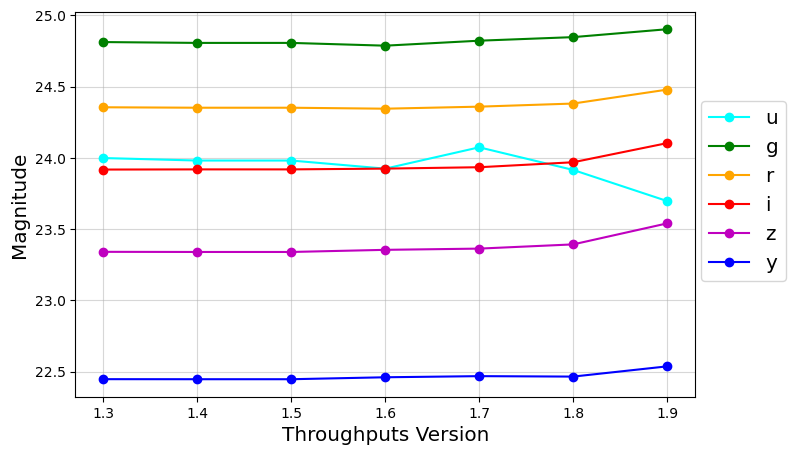

In [13]:
colors =  {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}
versions = list(m5s.keys())
plt.figure(figsize=(8, 5))
for f in 'ugrizy':
    plt.plot(versions, m5[f][:-2], color=colors[f], marker='o', linestyle='-', label=f)
plt.legend(loc=(1.01, .3), fancybox=True, fontsize='x-large')
plt.grid(True, alpha=0.5)
plt.ylabel("Magnitude", fontsize='x-large')
plt.xlabel("Throughputs Version", fontsize='x-large')

In [14]:
d = m5[4:7]
(d - d.loc['m5 for 1.7'].values).round(2)

,u,g,r,i,z,y
m5 for 1.7,0.00,0.00,0.00,0.00,0.00,0.00
m5 for 1.8,-0.16,0.03,0.02,0.03,0.03,-0.00
m5 for 1.9,-0.38,0.08,0.12,0.17,0.18,0.07


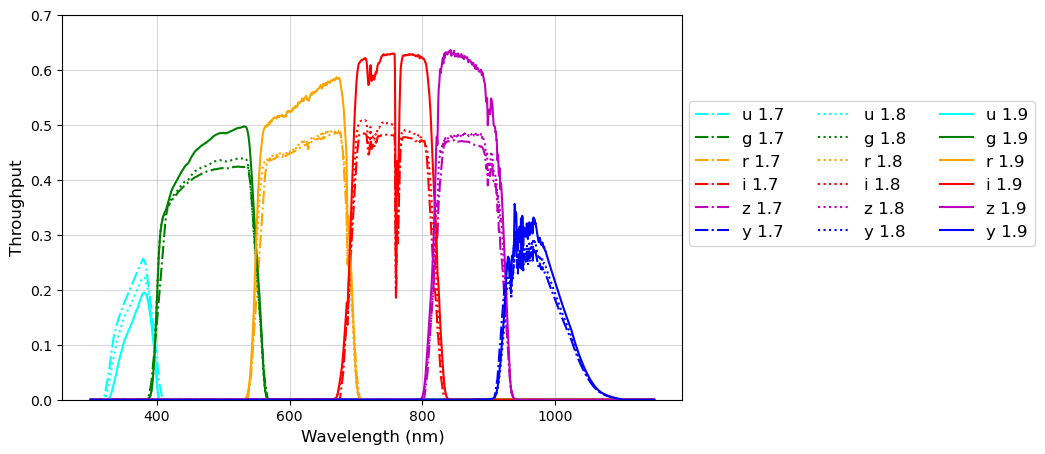

In [15]:
tt = ['1.7', '1.8', '1.9',]
colors =  {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}
linestyles = {'1.3': '-.', '1.4': '-.', '1.7': '-.', '1.8': ':', '1.9': '-'}

plt.figure(figsize=(8, 5))
for t in tt:
    for f in 'ugrizy':
        plt.plot(lsst_system[t][f].wavelen, lsst_system[t][f].sb, color=colors[f], linestyle=linestyles[t], label=f"{f} {t}")
plt.legend(loc=(1.01, 0.4), ncols=3, fancybox=True, fontsize='large')
plt.xlabel("Wavelength (nm)", fontsize='large')
plt.ylabel("Throughput", fontsize='large')
plt.ylim(0, 0.7)
plt.grid(True, alpha=0.5)

In [16]:
# Effective time calculation
# Fractional change in effective time is proportional to change in m5.
# HERE - longer time = better
delta_m5 = (m5[:-2] - m5.loc['m5 for 1.7'].values)
dtime = np.power(10, 0.8 * (delta_m5))
dtime.index = [i[0].replace('m5 for', "Teff for") for i in dtime.index.values]
dtime[-3:]

,u,g,r,i,z,y
Teff for 1.7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Teff for 1.8,0.746387,1.047177,1.040974,1.066202,1.055972,0.994164
Teff for 1.9,0.499388,1.159827,1.246067,1.365301,1.385210,1.134620


In [17]:
# SRD time distribution is approximate weight per filter (like the distribution of visits in the SRD)
SRD_time_distribution = pd.Series({'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194})
SRD_time_distribution, SRD_time_distribution.sum()

(u    0.068
 g    0.097
 r    0.223
 i    0.223
 z    0.194
 y    0.194
 dtype: float64,
 0.9989999999999999)

In [18]:
# So weight the difference in effective time by the fraction of visits in that filter -- look at the sum to see the overall effect.
weighted_dtime = dtime.multiply(SRD_time_distribution)
weighted_dtime['sum'] = weighted_dtime.sum(axis=1)
weighted_dtime.round(2)

,u,g,r,i,z,y,sum
Teff for 1.3,0.06,0.10,0.22,0.22,0.19,0.19,0.96
Teff for 1.4,0.06,0.09,0.22,0.22,0.19,0.19,0.96
Teff for 1.5,0.06,0.09,0.22,0.22,0.19,0.19,0.96
Teff for 1.6,0.05,0.09,0.22,0.22,0.19,0.19,0.96
Teff for 1.7,0.07,0.10,0.22,0.22,0.19,0.19,1.00
Teff for 1.8,0.05,0.10,0.23,0.24,0.20,0.19,1.02
Teff for 1.9,0.03,0.11,0.28,0.30,0.27,0.22,1.22


In [19]:
pd.DataFrame(weighted_dtime.loc[["Teff for 1.7", "Teff for 1.9"], 'sum']).round(2)

,sum
Teff for 1.7,1.00
Teff for 1.9,1.22
